In [43]:
# Bybitが提供している公式のライブラリを用いる
# 使い方は以下のURL参照
# https://bybit-exchange.github.io/docs/linear/#t-constructingtherequest
import bybit
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Bybit API Key (test net)
api_key = "your API key"
api_secret = "your Secret key"


# クラスのインスタンス化
# Bybitにはdemo用のtest環境と取引用の本番環境の2種類があり、それぞれでAPI_keyが異なる
# test = Trueにすることでdemo用環境を指定できる

client = bybit.bybit(test=True, api_key = api_key, api_secret = api_secret)

In [13]:
# ローソク足データを取得する 取得できるのは一度に最大200件まで
# 取得したいデータの期間 ここで指定した日時から最大200件のローソク足データが手に入る
date_str = '2021/9/1 00:00'
date_dt = datetime.strptime(date_str, '%Y/%m/%d %H:%M')
target_unix = date_dt.timestamp()
print(target_unix)

1630422000.0


In [18]:
# ローソク足の時間足はintervalで指定 60 = 1時間足
# 1時間足以外に1分足から日足 月足 色々ある　詳細は公式github参照
# 取得したいデータの期間をunix時間で指定しないといけないことがやや面倒

Historical_data = client.LinearKline.LinearKline_get(
    symbol="BTCUSDT",interval="60", **{'from': target_unix}).result()

In [19]:
print(Historical_data)

({'ret_code': 0, 'ret_msg': 'OK', 'ext_code': '', 'ext_info': '', 'result': [{'id': 21990413, 'symbol': 'BTCUSDT', 'period': '60', 'interval': '60', 'start_at': 1630422000, 'open_time': 1630422000, 'volume': 124.369, 'open': 47256, 'high': 47484.5, 'low': 47242, 'close': 47443, 'turnover': 5900438.467}, {'id': 21992919, 'symbol': 'BTCUSDT', 'period': '60', 'interval': '60', 'start_at': 1630425600, 'open_time': 1630425600, 'volume': 165.491, 'open': 47443, 'high': 47580, 'low': 47323.5, 'close': 47387, 'turnover': 7842122.017}, {'id': 21995430, 'symbol': 'BTCUSDT', 'period': '60', 'interval': '60', 'start_at': 1630429200, 'open_time': 1630429200, 'volume': 116.118, 'open': 47387, 'high': 47439.5, 'low': 47079.5, 'close': 47145.5, 'turnover': 5474441.169}, {'id': 21997918, 'symbol': 'BTCUSDT', 'period': '60', 'interval': '60', 'start_at': 1630432800, 'open_time': 1630432800, 'volume': 202.217, 'open': 47145.5, 'high': 47399.5, 'low': 47083.5, 'close': 47350.5, 'turnover': 9575076.0585}, 

# 返り値のparameter
id: 多分データ管理用に割り振られた番号　そんな重要じゃなさそう
'ret_code': 0, 'ret_msg': 'OK', 'ext_code': '', 'ext_info これらはAPIリクエストが成功したかどうかのメッセージ

データはresult以降に格納されている
以下 result内部のparameterについて

symbol: 取引ペア

period: 時間足

start_at, open_time: 時間 unix timeで入ってる startとopenでどう違うのかは不明

open,high,low,close: 始値,高値,安値,終値

volume: 取引数量

turnover: ? 売り上げという意味らしいがvolumeと何が違うのか不明

time_now:　プログラムを実行したときのunix時間

In [29]:
# resultだけを取ってくる
Data = Historical_data[0]['result']
print(Data)
print(len(Data))

[{'id': 21990413, 'symbol': 'BTCUSDT', 'period': '60', 'interval': '60', 'start_at': 1630422000, 'open_time': 1630422000, 'volume': 124.369, 'open': 47256, 'high': 47484.5, 'low': 47242, 'close': 47443, 'turnover': 5900438.467}, {'id': 21992919, 'symbol': 'BTCUSDT', 'period': '60', 'interval': '60', 'start_at': 1630425600, 'open_time': 1630425600, 'volume': 165.491, 'open': 47443, 'high': 47580, 'low': 47323.5, 'close': 47387, 'turnover': 7842122.017}, {'id': 21995430, 'symbol': 'BTCUSDT', 'period': '60', 'interval': '60', 'start_at': 1630429200, 'open_time': 1630429200, 'volume': 116.118, 'open': 47387, 'high': 47439.5, 'low': 47079.5, 'close': 47145.5, 'turnover': 5474441.169}, {'id': 21997918, 'symbol': 'BTCUSDT', 'period': '60', 'interval': '60', 'start_at': 1630432800, 'open_time': 1630432800, 'volume': 202.217, 'open': 47145.5, 'high': 47399.5, 'low': 47083.5, 'close': 47350.5, 'turnover': 9575076.0585}, {'id': 22000452, 'symbol': 'BTCUSDT', 'period': '60', 'interval': '60', 'sta

In [50]:
Date = []
Close_price = []
for i in range(len(Data)):
    Date.append(datetime.fromtimestamp(Data[i]['open_time']))
    Close_price.append(Data[i]['close'])

Text(0.5, 1.0, 'BTC price change in Bybit')

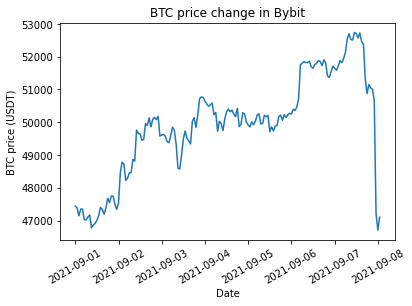

In [57]:
plt.plot(Date, Close_price)
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('BTC price (USDT)')
plt.title('BTC price change in Bybit')